## Estimate dMMSB in by spectral clustering. Main steps:
+ Estimate memberships and $B$ at each time point separately
+ Match the results at different time points by permute the $K$ (number of clusters) coordinates of some memberships. Such permutation is necessary becuase the result of clustering at a single time point remains the same after permuting the estimated labels, but the label of a single node from time to time will not change too much: we need some permutation to gurantee this.
+ Spectral clustering is much faster than the Bayesian approach (EM).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, multinomial, bernoulli
import time

import random
from numpy.random import seed
%matplotlib inline

from simulation_utils import *
from score_utils import *

# Single Time Point

In [2]:
random.seed(0)
seed(0)

# parameters
N = 100
K = 3
p_in = 1
p_out = 0.
B = (p_in - p_out) * np.identity(K) + p_out * np.ones((K,K))

mu = np.array([0 for i in range(K)])
Sigma = 10 * np.eye(K)


# E, label, Pi, gamma, Z_indicator = generate_LNMMSB(N,K,mu,Sigma,B)
E, label, Pi, gamma, Z_indicator = generate_LNMMSB_symmetry(N,K,mu,Sigma,B)

In [3]:
result = mix_score(A = E,K = 3)
R = result[0]
vertices = result[2]
centers = result[3]
Pi_hat = result[4]

In [4]:
B_hat = result[8]
print(B_hat.round(4))
print(B)

[[0.6852 0.1381 0.1532]
 [0.1381 0.7068 0.179 ]
 [0.1532 0.179  0.631 ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


+ This figure shows how we estimate memberships: each point is an embedded point of a node in the network, and green points are the vertices of the 3 clusters, after identify these 3 vertices we can estimate memberships by calculating the convex combination coefficients of the 3 vertices represeting each embedded point of node in the network. 

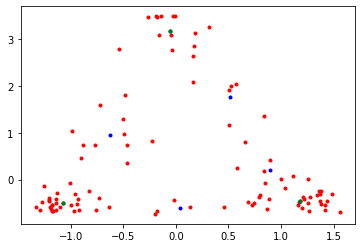

In [5]:
plt.plot(R[:,0],R[:,1],'r.')
plt.plot(centers[:,0],centers[:,1],'b.')
plt.plot(vertices[:,0],vertices[:,1],'g.')

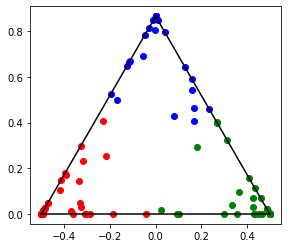

In [6]:
f = visual_membership(Pi_hat)

mismatched cluster labels:  3


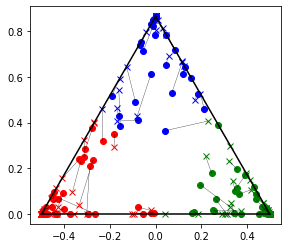

In [7]:
# Pi_hat is shown as 'x' and Pi is shown as 'o'
f = compare_membership(Pi,Pi_hat,use_gamma = False)

Try with more nodes and larger Sigma

In [8]:
random.seed(0)
seed(0)

# parameters
N = 500
K = 3
p_in = 1
p_out = 0.
B = (p_in - p_out) * np.identity(K) + p_out * np.ones((K,K))

mu = np.array([0 for i in range(K)])
Sigma = 100 * np.eye(K)


# E, label, Pi, gamma, Z_indicator = generate_LNMMSB(N,K,mu,Sigma,B)
E, label, Pi, gamma, Z_indicator = generate_LNMMSB_symmetry(N,K,mu,Sigma,B)

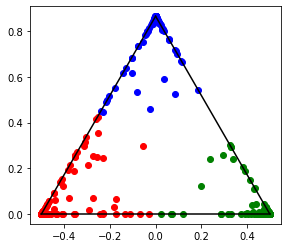

In [9]:
f = visual_membership(Pi)

In [10]:
# f = visual_network(E,label)
# f

+ The estimate of $B$ gets better for larger Sigma

In [11]:
result = mix_score(A = E,K = 3)
R = result[0]
vertices = result[2]
centers = result[3]
Pi_hat = result[4]
B_hat = result[8]
print(B_hat.round(4))
print(B)

[[0.884  0.0751 0.0389]
 [0.0751 0.8557 0.0538]
 [0.0389 0.0538 0.9043]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


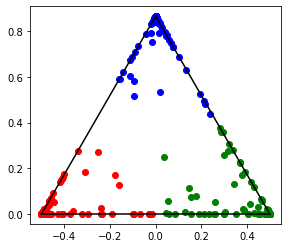

In [12]:
f = visual_membership(Pi_hat)

show the simplex structure given by eigenvector ratios

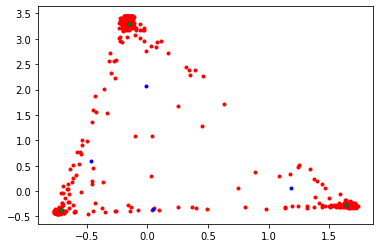

In [13]:
plt.plot(R[:,0],R[:,1],'r.')
plt.plot(centers[:,0],centers[:,1],'b.')
plt.plot(vertices[:,0],vertices[:,1],'g.')

mismatched cluster labels:  2


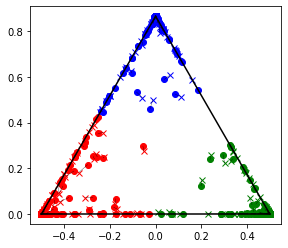

In [14]:
# Pi_hat is shown as 'x' and Pi is shown as 'o'
f = compare_membership(Pi,Pi_hat,use_gamma = False)

# Multiple Time Points

In [15]:
def generate_dMMSB(N,K,T,nv,Phi,Sigma_e,Sigma,l,psi,b,B = None):
    '''
    generate T networks from a modified dMMSB
    -------------------
    Arguments:
        Sigma (K x K x T array)
    
    Returns
        E (T x N x N array): E[:,:,t] is the observed adjacency matrix at time t
        Mu (T x K array): Mu[:,t] is
        Label (T x N array)
        Pi (T x N x K array)
        Gamma (T x N x K array)
        Z_indicator (N x N x T x 2 array): Z_indicator[i,j,t,0] is the index of 1 in z_{i->j}^{(t)}, 
                              Z_indicator[i,j,t,1] is the index of 1 in z_{j->i}^{(t)}
        B (T x K x K array):
    '''
    Mu = np.zeros((T,K))
    Pi = np.zeros((T,N,K))
    Gamma = np.zeros((T,N,K))
    E = np.zeros((T,N,N)) # observed adjacency matrix of the network
    Z_indicator = np.zeros((T,N,N,2))
    Q = np.zeros((T,N,N))
    Label = np.zeros((T,N))

    Mu[0,:] = np.random.multivariate_normal(nv,Phi)
    gamma = np.random.multivariate_normal(Mu[0,:],Sigma[0,:,:],size = N) #[N,K]
    C = np.log(np.exp(gamma).sum(axis = 1,keepdims = True))
    C = np.tile(C,(1,K))
    pi = np.exp(gamma - C)
    label = pi.argmax(axis = 1)
    Pi[0,:,:] = pi
    Gamma[0,:,:] = gamma
    Label[0,:] = label
    
    for t in range(1,T):
        epsilon = np.random.multivariate_normal(np.zeros(K),Sigma_e,size = N) #[N,K]
        gamma_pre = gamma.copy() 
        gamma = gamma_pre + epsilon
        C = np.log(np.exp(gamma).sum(axis = 1,keepdims = True))
        C = np.tile(C,(1,K))
        pi = np.exp(gamma - C)
        label = pi.argmax(axis = 1)
        Pi[t,:,:] = pi
        Gamma[t,:,:] = gamma
        Label[t,:] = label
        
    if B is None:
        B = np.zeros((T,K,K))
        eta = l + np.sqrt(psi) * np.random.randn(K**2).reshape((K,K))
        B[0,:,:] = np.exp(eta)/(1 + np.exp(eta))
        for t in range(1,T):
            eta = b * eta + np.sqrt(psi) * np.random.randn(K**2).reshape((K,K))
            B[t,:,:] = np.exp(eta)/(1 + np.exp(eta))

    for t in range(T):
        #### generate z
        Z_indicator_t = np.zeros((N,N,2))
        for i in range(N):
            z_tmp = np.where(np.random.multinomial(1,Pi[t,i,:],2 * N))[1]
            Z_indicator_t[i,:,0] = z_tmp[0:N]
            Z_indicator_t[:,i,1] = z_tmp[N:(2 * N)]
        Z_indicator[t,:,:,:] = Z_indicator_t.astype(int)
        Z_indicator_t = Z_indicator_t.reshape((N * N,2)).astype(int)
        B_t = B[t,:,:]
        Q_t = B_t[Z_indicator_t[:,0],Z_indicator_t[:,1]].reshape(N,N)
        # E_t is the observed adjacency matrix at time t
        E_t = np.random.binomial(1,Q_t)
#         if symmetry:
#             E_t = np.triu(E_t,1) + np.triu(E_t,1).T
        E[t,:,:] = E_t
        Q[t,:,:] = Q_t
    Label = Label.astype(int)
    return E, Mu.T, Label.T, Pi, Gamma, Z_indicator, B

## Case I

+ The original dMMSB model in "A state-space mixed membership blockmodel for dynamic network tomography" has the issue that membership weights of nodes do not have temporal dependence structure: they are sampled independently from a log-normal distribution at each time point. The parameters of the log-normal distribution have temporal dependence, but this does not help because of the independent generation. 
+ As is shown below, the mismatch of true community labels at neighboring time points are so large that it's impossible to estimate all community labels in a purly unsupervised manner (e.g., a label matching process that minimize the mismatch between neighboring time points).
+ Therefore, we slightly modify the generative model and so that membership weights are generated in a random-walk style.

In [16]:
random.seed(0)
seed(0)

# parameters
N = 100
K = 3
T = 4
p_in = 1
p_out = 0.
B = (p_in - p_out) * np.identity(K) + p_out * np.ones((K,K))
B_ = np.array([B for t in range(T)]).transpose((1,2,0))
l = 0
psi = 1
b = 1

nv = np.array([0 for i in range(K)])
Phi = 0.01 * np.eye(K)
A = np.eye(K)
Sigma = 10 * np.array([np.eye(K) for t in range(T)])
Sigma_ = Sigma.transpose((1,2,0))

E, Mu, Label, Pi, Gamma, Z_indicator, B_ = generate_dMMSB_original(N,K,T,nv,Phi,A,Sigma_,l,psi,b,B_)

63
70
72
mismatched cluster labels:  0


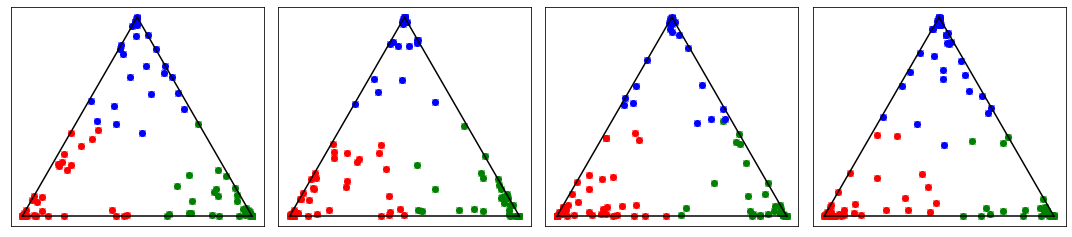

In [17]:
for i in range(1,T):
    print(mismatch_two_pi(Pi[i - 1], Pi[i]))
f = compare_membership_T(Pi,Pi,use_gamma = False)

### modified dMMSB

In [18]:
random.seed(0)
seed(0)

# parameters
N = 100
K = 3
T = 4
p_in = 1
p_out = 0.
B = (p_in - p_out) * np.identity(K) + p_out * np.ones((K,K))
B_ = np.array([B for t in range(T)])
l = 0
psi = 1
b = 1

nv = np.array([0 for i in range(K)])
Phi = 0.01 * np.eye(K)
Sigma_e = 0.1 * np.eye(K)
Sigma = 10 * np.array([np.eye(K) for t in range(T)])

E, Mu, Label, Pi, Gamma, Z_indicator, B_ = generate_dMMSB(N,K,T,nv,Phi,Sigma_e,Sigma,l,psi,b,B_)

5
7
3
mismatched cluster labels:  0


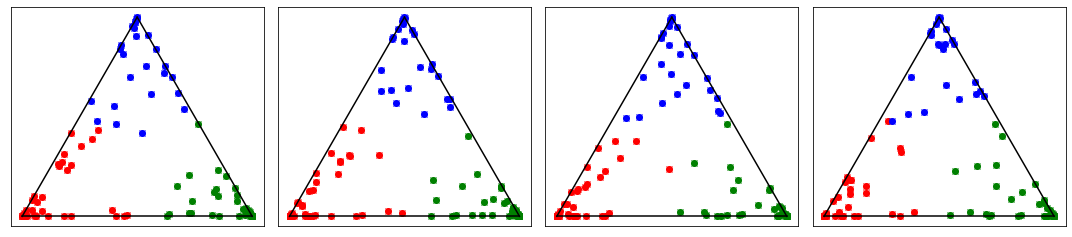

In [19]:
for i in range(1,T):
    print(mismatch_two_pi(Pi[i - 1], Pi[i]))
f = compare_membership_T(Pi,Pi,use_gamma = False)

In [20]:
result = score_dMMSB(K = 3, E = E)
Pi_hat, B_hat = result[:2]

In [21]:
for t in range(T):
    print('--------- B',t,' ----------')
    print(B_hat[t].round(4))

--------- B 0  ----------
[[0.7508 0.1323 0.1389]
 [0.1491 0.6814 0.1791]
 [0.1421 0.1953 0.6361]]
--------- B 1  ----------
[[0.7265 0.1437 0.1421]
 [0.1323 0.7363 0.1632]
 [0.1537 0.173  0.6336]]
--------- B 2  ----------
[[0.7363 0.1526 0.1608]
 [0.1436 0.7161 0.1764]
 [0.1556 0.1657 0.6379]]
--------- B 3  ----------
[[0.7299 0.1299 0.1512]
 [0.1434 0.7341 0.1431]
 [0.1389 0.1572 0.6228]]


Pi_hat is shown as 'x' and Pi is shown as 'o'

mismatched cluster labels:  11


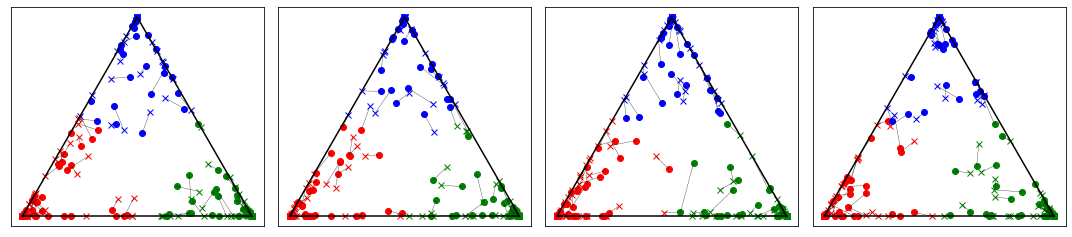

In [22]:
f = compare_membership_T(Pi,Pi_hat,use_gamma = False)

## Case II

In [23]:
random.seed(0)
seed(0)

# parameters
N = 100
K = 3
T = 4
p_in = 1
p_out = 0.
B = (p_in - p_out) * np.identity(K) + p_out * np.ones((K,K))
B[0,1] = 0.3
B[1,0] = 0.3
B_ = np.array([B for t in range(T)])
l = 0
psi = 1
b = 1

nv = np.array([0 for i in range(K)])
Phi = 0.01 * np.eye(K)
Sigma_e = 0.1 * np.eye(K)
Sigma = 10 * np.array([np.eye(K) for t in range(T)])

E, Mu, Label, Pi, Gamma, Z_indicator, B_ = generate_dMMSB(N,K,T,nv,Phi,Sigma_e,Sigma,l,psi,b,B_)

In [24]:
result = score_dMMSB(K = 3, E = E)
Pi_hat, B_hat = result[:2]

In [25]:
np.mean(np.array(result[1]),axis = 0)

array([[0.73202818, 0.19249109, 0.35615949],
       [0.20768675, 0.67693032, 0.17140398],
       [0.36838118, 0.16889452, 0.74102649]])

In [26]:
for t in range(T):
    print('--------- B',t,' ----------')
    print(B_[t].round(4))

--------- B 0  ----------
[[1.  0.3 0. ]
 [0.3 1.  0. ]
 [0.  0.  1. ]]
--------- B 1  ----------
[[1.  0.3 0. ]
 [0.3 1.  0. ]
 [0.  0.  1. ]]
--------- B 2  ----------
[[1.  0.3 0. ]
 [0.3 1.  0. ]
 [0.  0.  1. ]]
--------- B 3  ----------
[[1.  0.3 0. ]
 [0.3 1.  0. ]
 [0.  0.  1. ]]


In [27]:
for t in range(T):
    print('--------- B_hat',t,' ----------')
    print(B_hat[t].round(4))

--------- B_hat 0  ----------
[[0.7084 0.2007 0.3518]
 [0.2281 0.691  0.1743]
 [0.3442 0.1678 0.7611]]
--------- B_hat 1  ----------
[[0.7721 0.1813 0.341 ]
 [0.2027 0.6615 0.1838]
 [0.377  0.1645 0.7594]]
--------- B_hat 2  ----------
[[0.7337 0.2113 0.3483]
 [0.2092 0.6672 0.1678]
 [0.3568 0.1911 0.7778]]
--------- B_hat 3  ----------
[[0.7138 0.1767 0.3836]
 [0.1907 0.6881 0.1597]
 [0.3955 0.1522 0.6659]]


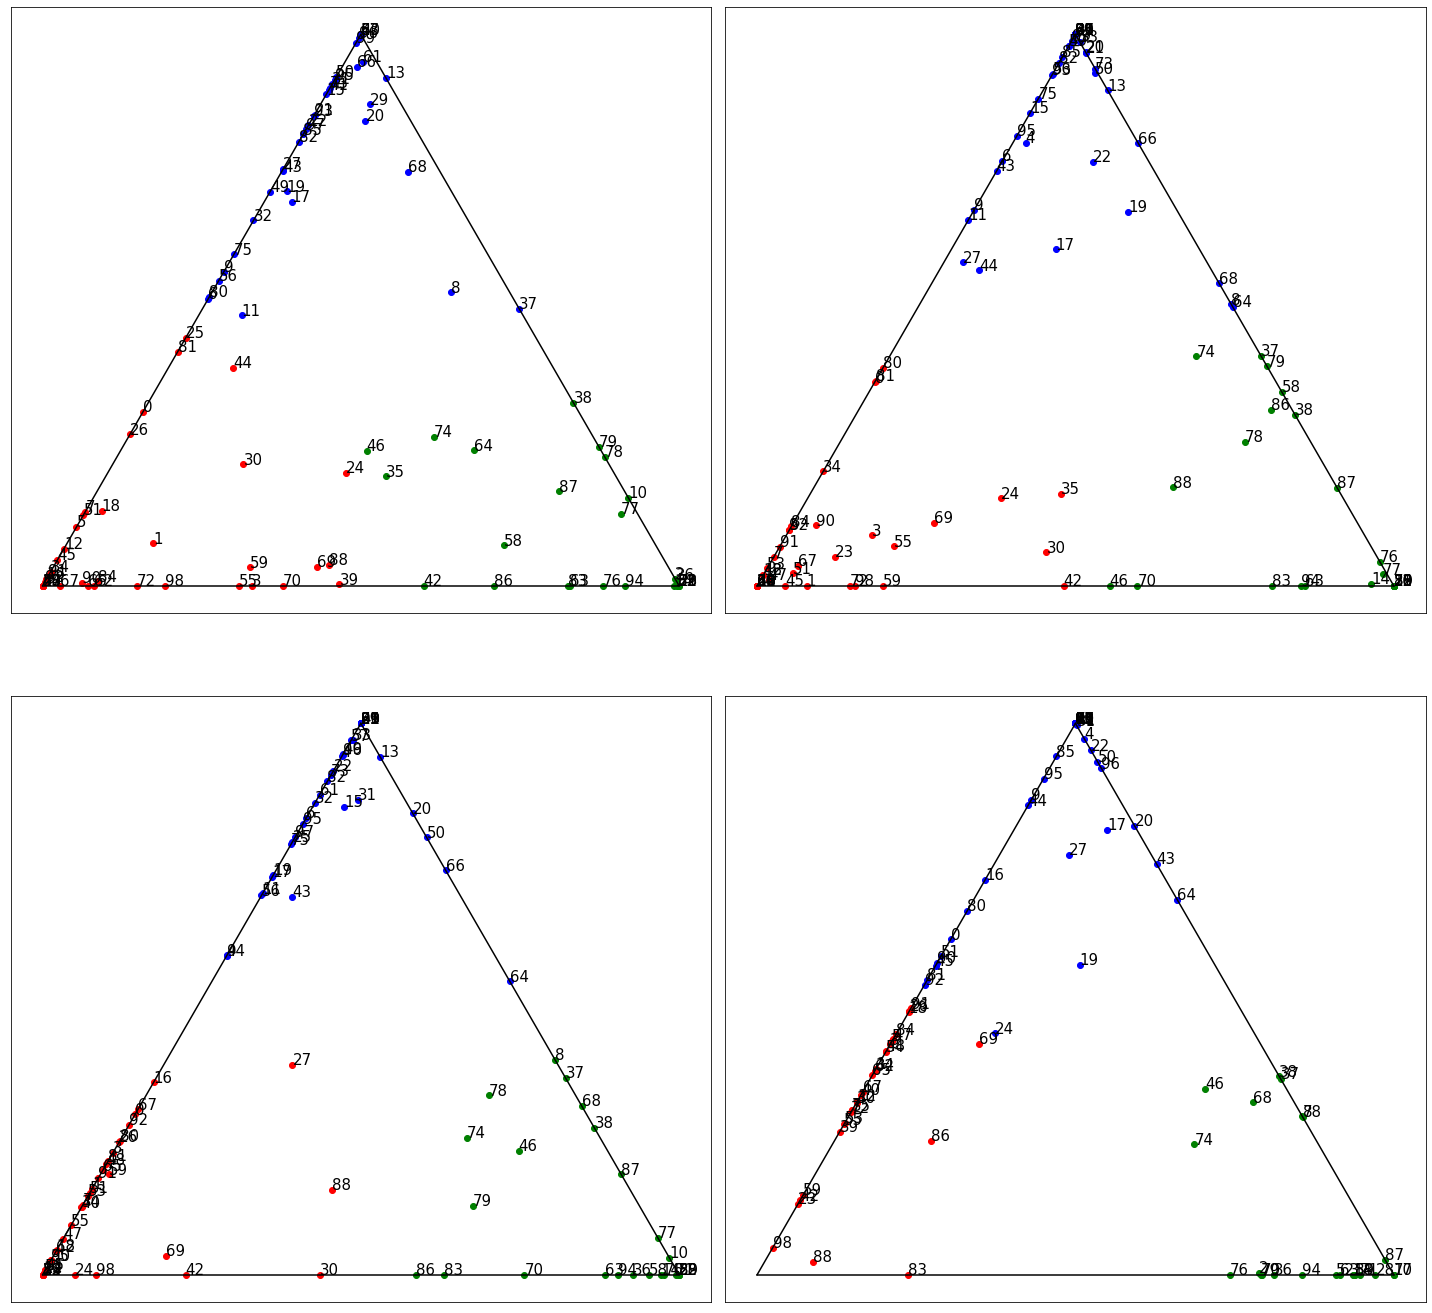

In [28]:
f = visual_membership_T(Pi_hat,nrow = 2,node_id = True)

Pi_hat is shown as 'x' and Pi is shown as 'o'

mismatched cluster labels:  29


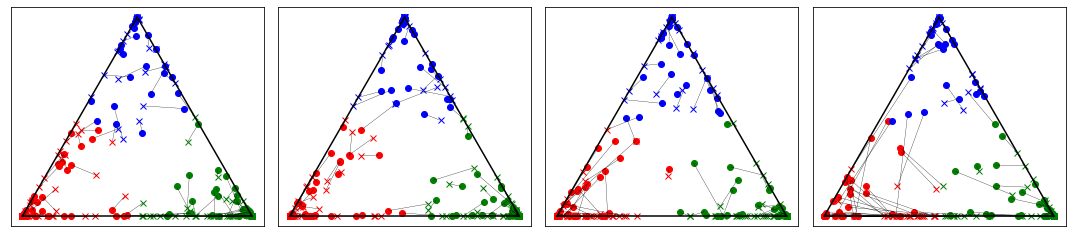

In [29]:
f = compare_membership_T(Pi,Pi_hat,use_gamma = False)

## Case III

In [30]:
random.seed(0)
seed(0)

# parameters
N = 100
K = 3
T = 4
p_in = 1
p_out = 0.

B = np.zeros((K,K))
B[0,0] = 0.45
B[1,1] = 0.5
B[2,2] = 0.4
B[0,2] = 0.05

B_ = np.array([B for t in range(T)])
l = 0
psi = 1
b = 1

nv = np.array([0 for i in range(K)])
Phi = 0.01 * np.eye(K)
Sigma_e = 0.1 * np.eye(K)
Sigma = 10 * np.array([np.eye(K) for t in range(T)])

E, Mu, Label, Pi, Gamma, Z_indicator, B_ = generate_dMMSB(N,K,T,nv,Phi,Sigma_e,Sigma,l,psi,b,B_)

In [31]:
result = score_dMMSB(K = 3, E = E)
Pi_hat, B_hat = result[:2]

In [32]:
for t in range(T):
    print('--------- B',t,' ----------')
    print(B_[t].round(4))

--------- B 0  ----------
[[0.45 0.   0.05]
 [0.   0.5  0.  ]
 [0.   0.   0.4 ]]
--------- B 1  ----------
[[0.45 0.   0.05]
 [0.   0.5  0.  ]
 [0.   0.   0.4 ]]
--------- B 2  ----------
[[0.45 0.   0.05]
 [0.   0.5  0.  ]
 [0.   0.   0.4 ]]
--------- B 3  ----------
[[0.45 0.   0.05]
 [0.   0.5  0.  ]
 [0.   0.   0.4 ]]


In [33]:
for t in range(T):
    print('--------- B_hat',t,' ----------')
    print(B_hat[t].round(4))

--------- B_hat 0  ----------
[[0.3788 0.0533 0.0694]
 [0.0819 0.317  0.1091]
 [0.0602 0.0811 0.227 ]]
--------- B_hat 1  ----------
[[0.3733 0.068  0.0743]
 [0.0633 0.3429 0.1173]
 [0.0714 0.0714 0.2398]]
--------- B_hat 2  ----------
[[0.4068 0.0652 0.0808]
 [0.0712 0.3069 0.087 ]
 [0.0875 0.0667 0.2675]]
--------- B_hat 3  ----------
[[0.3951 0.0705 0.0744]
 [0.0584 0.311  0.0892]
 [0.0722 0.0605 0.2848]]


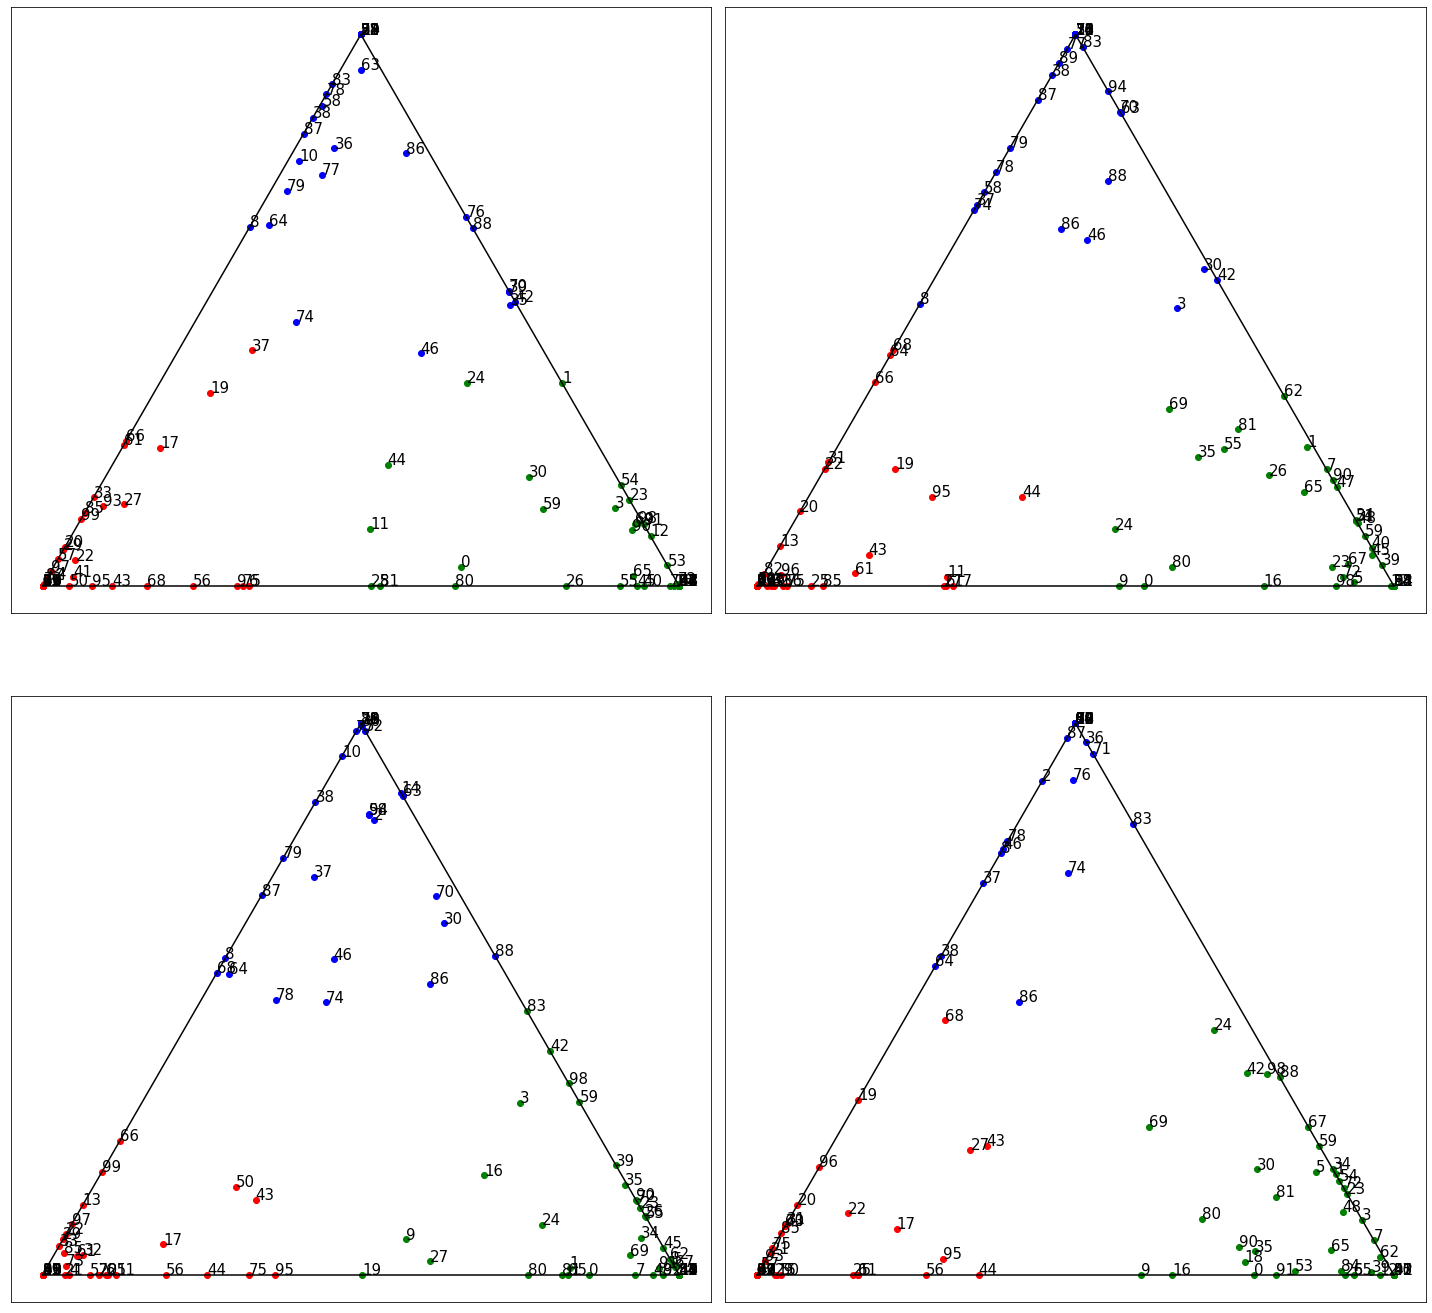

In [34]:
f = visual_membership_T(Pi_hat,nrow = 2,node_id = True)

Pi_hat is shown as 'x' and Pi is shown as 'o'

mismatched cluster labels:  20


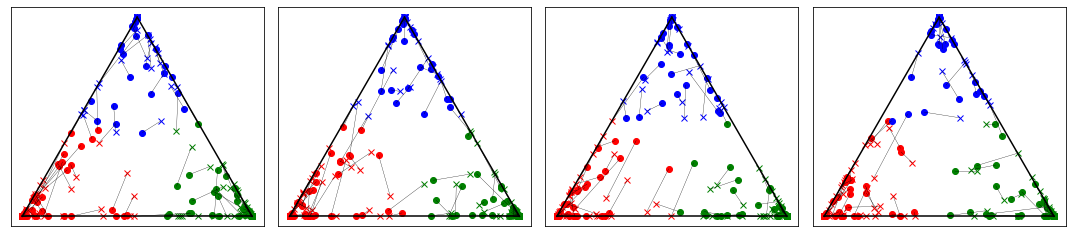

In [35]:
f = compare_membership_T(Pi,Pi_hat,use_gamma = False)

### Reference
+ A state-space mixed membership blockmodel for dynamic network tomography. Eric P. Xing, Wenjie Fu, Le Song.
+ Estimating network memberships by simplex vertex hunting. Jiashun Jin, Zheng Tracy Ke, Shengming Luo